## Import

In [1]:
import numpy as np
from scipy.io import loadmat
import keras
from keras.models import Sequential, Model
from keras.models import load_model
from keras.utils import plot_model
from keras.layers import Input, Dense, Activation, LSTM, SimpleRNN, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten
import keras.backend as K
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import Sequence, to_categorical
from keras.callbacks import TensorBoard


C:\Users\Zed_Luz\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Import the IMU Data

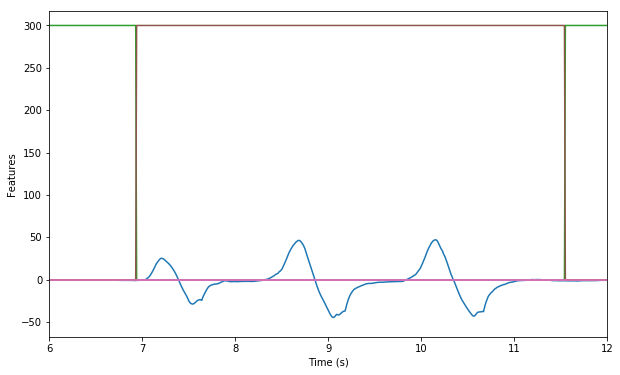

In [2]:
IfReadModel = True
# Import the data from the mat file

data_in = loadmat('../../Datasets/ashwin_testdata/walk_data_ashwin.mat')
X = data_in['imu_features']
Y = data_in['lm_label']/300
Ytemp = np.argwhere(Y)[:, 1]
Yint = np.zeros(Ytemp.shape)
for i in range(Ytemp.shape[0]):
    if Ytemp[i] == 1:
        Yint[i] = 0
    elif Ytemp[i] == 4:
        Yint[i] = 1
    elif Ytemp[i] == 5:
        Yint[i] = 2
            
Y_prep = to_categorical(Yint)


 # Get some statistics from the data
exp_dur = X.shape[0]/100.0
nfeat = X.shape[1]
t = np.linspace(0, exp_dur, X.shape[0])

# Plot parts of the data
plt.figure(figsize=(10, 6))
plt.plot(t, X[:, 56])
plt.plot(t, Y*300)
plt.xlim([6, 12])
plt.ylabel('Features')
plt.xlabel('Time (s)')
plt.show()


## Normalization

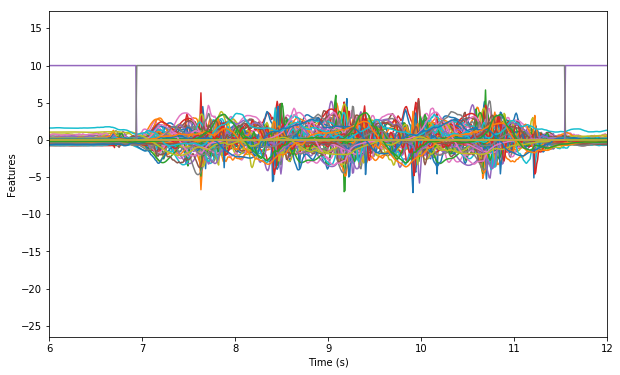

In [3]:
scale_factors = np.std(X, axis=0)
mean_values = np.mean(X, axis=0)
X_prep = (X - mean_values)/scale_factors
#print("After normalizing: ")
#print("Mean is: ", np.mean(X_prep, axis=0))
#print("Stdev. is: ", np.std(X_prep, axis=0))

# Plot all of the normalized data
plt.figure(figsize=(10, 6))
plt.plot(t, X_prep)
plt.plot(t, Y*10)
plt.xlim([6, 12])
plt.ylabel('Features')
plt.xlabel('Time (s)')
plt.show()

## Function to split the data and labels into windows that are causally aligned.

In [4]:
def get_sub_sequences(data_array, y_array, window_size=120, step_size=90, dims=None, seq_out=False, causal=True):
    rows = data_array.shape[0]
    cols = data_array.shape[1]

    if dims == None:
        outdims = [i for i in range(cols)]
    else:
        outdims = dims
        
    sequences = rows//step_size
    out_x = np.zeros((sequences, window_size, len(outdims)))
    if seq_out:
        out_y = np.zeros((sequences, window_size, y_array.shape[1]))
    else:
        out_y = np.zeros((sequences, y_array.shape[1]))
        
    idxs = range(window_size, rows, step_size)    
    
    for i, j in enumerate(idxs):
        out_x[i, :, :] = data_array[j-window_size:j, outdims]
        if seq_out:
            out_y[i, :, :] = y_array[j-window_size:j, :]
        else:
            out_y[i, :] = y_array[j, :]
    
    return out_x, out_y

## Generate dataset of sub-sequences

In [5]:
X_seq, Y_seq = get_sub_sequences(X_prep, Y_prep, window_size=120, step_size=1)
X_seq = np.reshape(X_seq, newshape=(X_seq.shape[0], X_seq.shape[1], X_seq.shape[2], 1))

## CNNs-Model

In [10]:
IfReadModel = False
if IfReadModel:
    cnn_model1 = load_model('CNN_Model.h5')
else:
    cnn_model1 = Sequential()
    cnn_model1.add(Conv2D(filters=16, kernel_size=9, input_shape=(120, 63, 1),
                          data_format='channels_last', activation='relu', padding='valid'))
    cnn_model1.add(MaxPooling2D(pool_size=(10, 3), padding='valid'))
    cnn_model1.add(Flatten())
    cnn_model1.add(Dense(3, activation='softmax'))
    #cnn_model1.add(Dense(3, activation='softmax'))
    cnn_model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    cnn_model1.summary()
    print("X_seq_train: ", X_seq.shape)
    print("Y_seq_train: ", Y_seq.shape)
    dlcallback = keras.callbacks.TensorBoard(log_dir='./TensorboardLogs', histogram_freq=10,
                                             write_graph=True, write_images=True, write_grads=True, batch_size=128,
                                             update_freq='batch')
    cnn_model1.fit(X_seq, Y_seq, validation_split=0.33, batch_size=128, callbacks=[dlcallback])
    #plot_model(cnn_model1, to_file='model.png') # Visualization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 112, 55, 16)       1312      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 18, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3168)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 9507      
Total params: 10,819
Trainable params: 10,819
Non-trainable params: 0
_________________________________________________________________
X_seq_train:  (61207, 120, 63, 1)
Y_seq_train:  (61207, 3)
Train on 41008 samples, validate on 20199 samples
Epoch 1/1
41008/41008 [==============================] - 279s 7ms/step - loss: 0.2182 - acc: 0.9391 - val_loss: 0.1075 - val_acc: 0.9643


InvalidArgumentError: You must feed a value for placeholder tensor 'dense_1_target' with dtype float and shape [?,?]
	 [[{{node dense_1_target}} = Placeholder[dtype=DT_FLOAT, shape=[?,?], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'dense_1_target', defined at:
  File "C:\Users\Zed_Luz\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Zed_Luz\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Zed_Luz\Anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\Zed_Luz\Anaconda3\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Users\Zed_Luz\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-68d4499ccb1a>", line 12, in <module>
    cnn_model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\keras\engine\training.py", line 238, in compile
    dtype=K.dtype(self.outputs[i]))
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 517, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1745, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 5019, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3272, in create_op
    op_def=op_def)
  File "C:\Users\Zed_Luz\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'dense_1_target' with dtype float and shape [?,?]
	 [[{{node dense_1_target}} = Placeholder[dtype=DT_FLOAT, shape=[?,?], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


## Plot-CNNs-Model

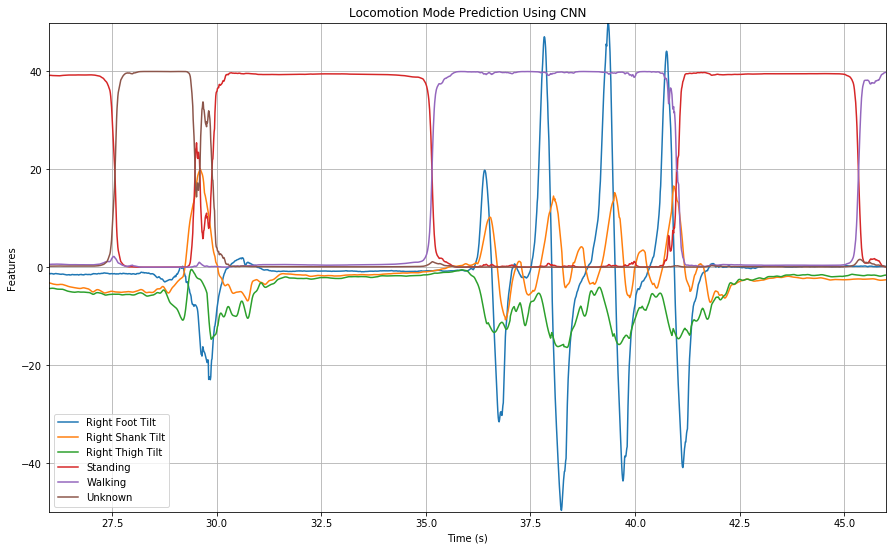

In [7]:
cnn_preds = cnn_model1.predict(X_seq) # Results of the prediction from the trained model

# ### Plot the results
plt.figure(figsize=(15, 9))
plt.plot(t, X[:, 56], label='Right Foot Tilt')
plt.plot(t, X[:, 57], label='Right Shank Tilt')
plt.plot(t, X[:, 58], label='Right Thigh Tilt')
plt.plot(t, cnn_preds[:, 0]*40, label='Standing')
plt.plot(t, cnn_preds[:, 1]*40, label='Walking')
plt.plot(t, cnn_preds[:, 2]*40, label='Unknown')
plt.xlim([26, 46])
plt.ylim([-50, 50])
plt.ylabel('Features')
plt.xlabel('Time (s)')
plt.title('Locomotion Mode Prediction Using CNN')
plt.grid()
plt.legend()
plt.show()